# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [2]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
import os
import copy
import torch
import pickle
import random
import numpy as np
import pandas as pd
from datetime import datetime
from collections import OrderedDict
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
SEED = 2023
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
BATCH_SIZE = 128

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)
torch.cuda.empty_cache()

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'test':
            transform = transforms.Compose([
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=0.25),
                transforms.RandomVerticalFlip(p=0.25),
                transforms.RandomCrop(224),
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [7]:
#train_dir = 'journey-springfield/train/simpsons_dataset'
#test_dir = 'journey-springfield/testset/testset'

TRAIN_DIR = Path('/drive/MyDrive/Deep Learning School/09_image_classification/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('/drive/MyDrive/Deep Learning School/09_image_classification/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

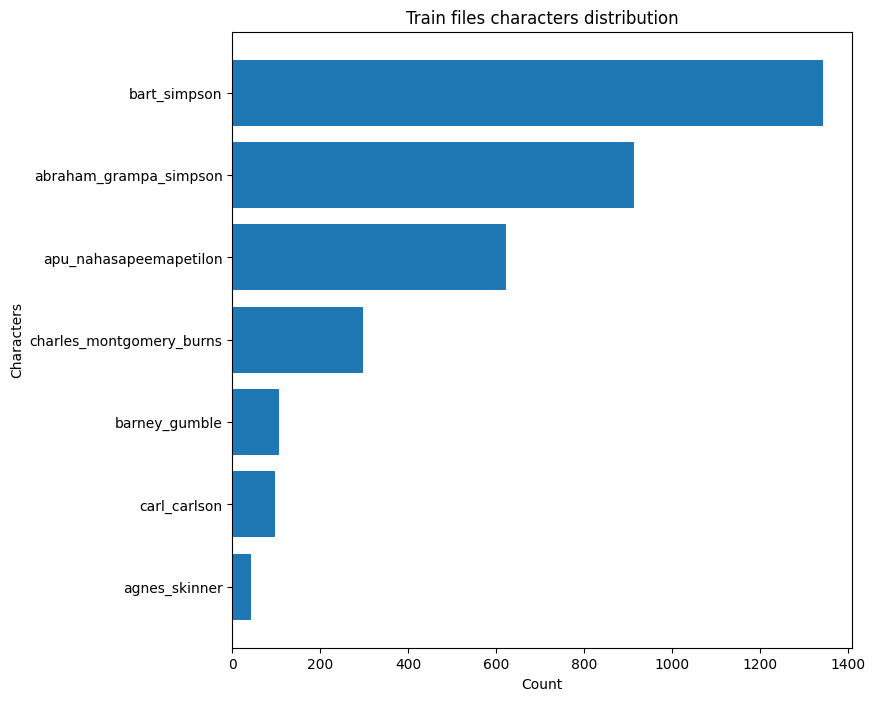

In [9]:
counts = pd.Series(train_val_labels).value_counts()

plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

In [30]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

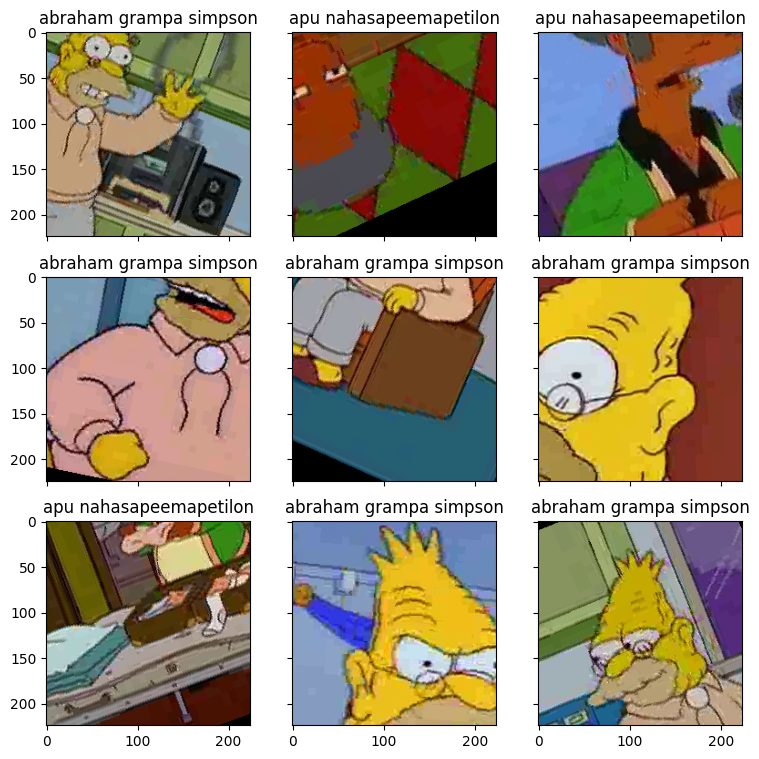

In [31]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(1000), dtype='int').item()
    img, label = train_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figx.imshow(img)

Мы видим, что количество изображений по персонажам из Симпсонов в тренировочном датасете распределны неравномерно, потребуется аугментация данных, для нее будем использовать WeightedRandomSampler из PyTorch

In [32]:
"""
count_weights = {k: 1/v for k,v in counts.items()}
sample_weights = len(train_files) * [0]

for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
    sample_weights[i] = label_weight
"""

'\ncount_weights = {k: 1/v for k,v in counts.items()}\nsample_weights = len(train_files) * [0]\n\nfor i, (data, label) in enumerate(tqdm(train_dataset)):\n    label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]\n    sample_weights[i] = label_weight\n'

In [34]:
#N = counts.max() * len(count_weights)
###количество сэмплов для сэмплера
#N

In [35]:
"""
from torch.utils.data import WeightedRandomSampler

train_sampler = WeightedRandomSampler(sample_weights, num_samples=9394, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
"""

'\nfrom torch.utils.data import WeightedRandomSampler\n\ntrain_sampler = WeightedRandomSampler(sample_weights, num_samples=9394, replacement=True)\ntrain_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)\n'

In [36]:
"""
effnet_b0_first = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)
effnet_b0_second = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)

for param in effnet_b0_first.parameters():
    param.requires_grad = False

num_features_first = effnet_b0_first.classifier[1].in_features
effnet_b0_first.classifier = nn.Sequential(
    nn.Linear(in_features=num_features_first, out_features=512, bias=True),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=512, out_features=42, bias=True)
)

for param in effnet_b0_second.features[:-3].parameters():
    param.requires_grad = False

num_features_second = effnet_b0_second.classifier[1].in_features
effnet_b0_first.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=num_features_second, out_features=42, bias=True)
)

effnet_b0_first = effnet_b0_first.cuda()
effnet_b0_second = effnet_b0_second.cuda()
"""

'\neffnet_b0_first = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)\neffnet_b0_second = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)\n\nfor param in effnet_b0_first.parameters():\n    param.requires_grad = False\n\nnum_features_first = effnet_b0_first.classifier[1].in_features\neffnet_b0_first.classifier = nn.Sequential(\n    nn.Linear(in_features=num_features_first, out_features=512, bias=True),\n    nn.BatchNorm1d(512),\n    nn.ReLU(),\n    nn.Dropout(p=0.3, inplace=True),\n    nn.Linear(in_features=512, out_features=42, bias=True)\n)\n\nfor param in effnet_b0_second.features[:-3].parameters():\n    param.requires_grad = False\n\nnum_features_second = effnet_b0_second.classifier[1].in_features\neffnet_b0_first.classifier = nn.Sequential(\n    nn.Dropout(p=0.3, inplace=True),\n    nn.Linear(in_features=num_features_second, out_features=42, bias=True)\n)\n\neffnet_b0_first = effnet_b0_firs

In [37]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [38]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [39]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [66]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [41]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.require_grad = False

num_features = model.fc.in_features
model.classifier = nn.Linear(num_features, 42)
model = model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Запустим обучение сети.

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=25, batch_size=128)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 4.762984165110257


epoch:   4%|▍         | 1/25 [01:23<33:14, 83.11s/it]


Epoch 001 train_loss: 4.7630     val_loss 2.1662 train_acc 0.3850 val_acc 0.7418
loss 0.9970194314107799


epoch:   8%|▊         | 2/25 [01:58<20:59, 54.76s/it]


Epoch 002 train_loss: 0.9970     val_loss 0.5317 train_acc 0.7864 val_acc 0.8481
loss 0.4897236042857077


epoch:  12%|█▏        | 3/25 [02:32<16:43, 45.63s/it]


Epoch 003 train_loss: 0.4897     val_loss 0.4302 train_acc 0.8496 val_acc 0.8668
loss 0.35490060201029433


epoch:  16%|█▌        | 4/25 [03:07<14:25, 41.21s/it]


Epoch 004 train_loss: 0.3549     val_loss 0.4290 train_acc 0.8882 val_acc 0.8598
loss 0.3101584973773358


epoch:  20%|██        | 5/25 [03:42<13:02, 39.10s/it]


Epoch 005 train_loss: 0.3102     val_loss 0.3683 train_acc 0.9041 val_acc 0.8715
loss 0.2916995533861783


epoch:  24%|██▍       | 6/25 [04:17<11:54, 37.61s/it]


Epoch 006 train_loss: 0.2917     val_loss 0.3356 train_acc 0.9018 val_acc 0.8972
loss 0.29456544930546524


epoch:  28%|██▊       | 7/25 [04:51<10:57, 36.54s/it]


Epoch 007 train_loss: 0.2946     val_loss 0.3266 train_acc 0.9010 val_acc 0.8937
loss 0.2886195019445007


epoch:  32%|███▏      | 8/25 [05:29<10:26, 36.88s/it]


Epoch 008 train_loss: 0.2886     val_loss 0.3180 train_acc 0.9034 val_acc 0.8879
loss 0.24507387090454041


epoch:  36%|███▌      | 9/25 [06:11<10:18, 38.66s/it]


Epoch 009 train_loss: 0.2451     val_loss 0.3294 train_acc 0.9170 val_acc 0.8995
loss 0.3130783241703839


epoch:  40%|████      | 10/25 [06:53<09:52, 39.50s/it]


Epoch 010 train_loss: 0.3131     val_loss 0.3455 train_acc 0.8983 val_acc 0.8902
loss 0.3288444368428582


epoch:  44%|████▍     | 11/25 [07:28<08:54, 38.19s/it]


Epoch 011 train_loss: 0.3288     val_loss 0.3711 train_acc 0.8924 val_acc 0.8879
loss 0.3343073708743484


epoch:  48%|████▊     | 12/25 [08:02<08:01, 37.01s/it]


Epoch 012 train_loss: 0.3343     val_loss 0.3035 train_acc 0.8967 val_acc 0.8972
loss 0.224756669052764


epoch:  52%|█████▏    | 13/25 [08:38<07:18, 36.55s/it]


Epoch 013 train_loss: 0.2248     val_loss 0.2961 train_acc 0.9291 val_acc 0.8995
loss 0.21478691150086612


epoch:  56%|█████▌    | 14/25 [09:12<06:35, 35.95s/it]


Epoch 014 train_loss: 0.2148     val_loss 0.2624 train_acc 0.9287 val_acc 0.9252
loss 0.19967075158890543


epoch:  60%|██████    | 15/25 [09:47<05:54, 35.43s/it]


Epoch 015 train_loss: 0.1997     val_loss 0.2432 train_acc 0.9271 val_acc 0.9276
loss 0.1635362705446646


epoch:  64%|██████▍   | 16/25 [10:21<05:16, 35.20s/it]


Epoch 016 train_loss: 0.1635     val_loss 0.2725 train_acc 0.9462 val_acc 0.9147
loss 0.23056797528768644


epoch:  68%|██████▊   | 17/25 [10:56<04:40, 35.06s/it]


Epoch 017 train_loss: 0.2306     val_loss 0.2636 train_acc 0.9267 val_acc 0.9171
loss 0.17806172280899732


epoch:  72%|███████▏  | 18/25 [11:30<04:03, 34.80s/it]


Epoch 018 train_loss: 0.1781     val_loss 0.2919 train_acc 0.9388 val_acc 0.9030
loss 0.1892630645950105


epoch:  76%|███████▌  | 19/25 [12:05<03:28, 34.76s/it]


Epoch 019 train_loss: 0.1893     val_loss 0.2663 train_acc 0.9330 val_acc 0.9159
loss 0.17003026089702886


epoch:  80%|████████  | 20/25 [12:39<02:52, 34.58s/it]


Epoch 020 train_loss: 0.1700     val_loss 0.2620 train_acc 0.9482 val_acc 0.9229
loss 0.14803745000625343


epoch:  84%|████████▍ | 21/25 [13:13<02:17, 34.50s/it]


Epoch 021 train_loss: 0.1480     val_loss 0.1905 train_acc 0.9540 val_acc 0.9393
loss 0.13921314577948787


epoch:  88%|████████▊ | 22/25 [13:48<01:43, 34.44s/it]


Epoch 022 train_loss: 0.1392     val_loss 0.2352 train_acc 0.9501 val_acc 0.9381
loss 0.12400328759314523


epoch:  92%|█████████▏| 23/25 [14:21<01:08, 34.28s/it]


Epoch 023 train_loss: 0.1240     val_loss 0.2412 train_acc 0.9575 val_acc 0.9217


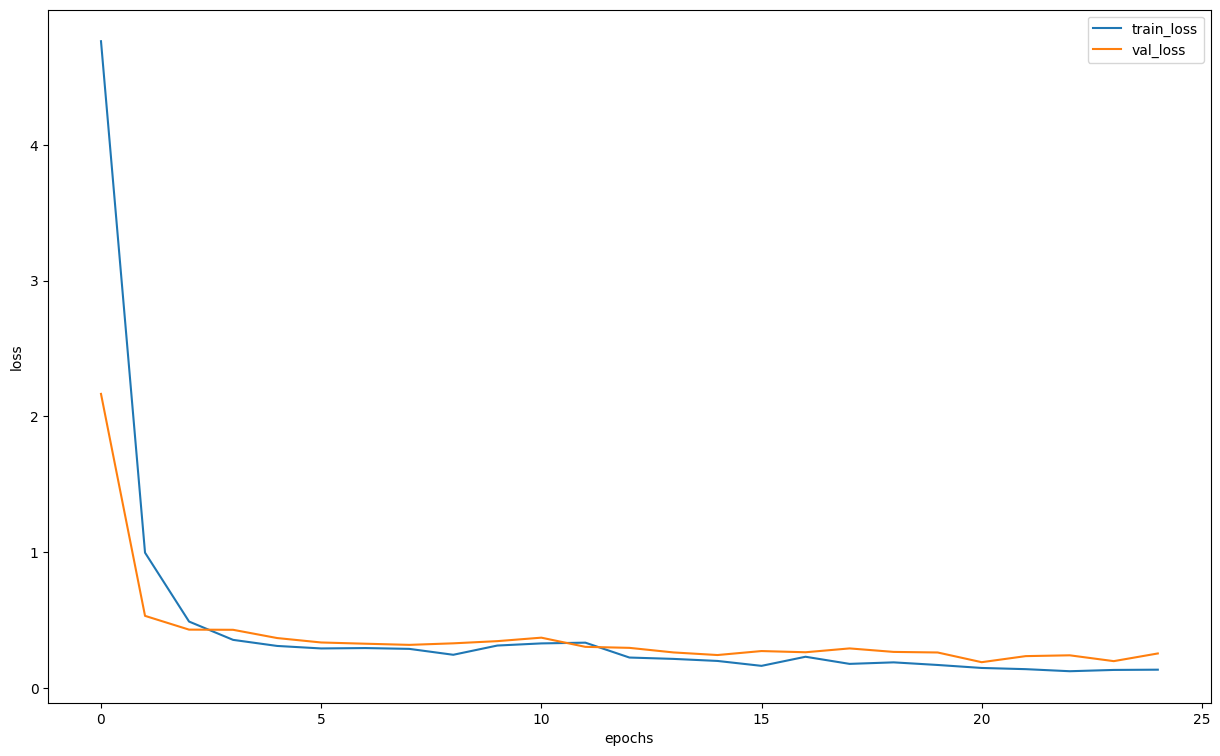

In [43]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [47]:
#history = train(train_dataset, val_dataset, model=effnet_b0_first, epochs=25, batch_size=128)

Построим кривые обучения

In [49]:
"""
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
"""

'\nloss, acc, val_loss, val_acc = zip(*history)\n\nplt.figure(figsize=(15, 9))\nplt.plot(loss, label="train_loss")\nplt.plot(val_loss, label="val_loss")\nplt.legend(loc=\'best\')\nplt.xlabel("epochs")\nplt.ylabel("loss")\nplt.show()\n'

In [50]:
#history = train(train_dataset, val_dataset, model=effnet_b0_second, epochs=25, batch_size=128)

In [51]:
"""
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
"""

'\nloss, acc, val_loss, val_acc = zip(*history)\n\nplt.figure(figsize=(15, 9))\nplt.plot(loss, label="train_loss")\nplt.plot(val_loss, label="val_loss")\nplt.legend(loc=\'best\')\nplt.xlabel("epochs")\nplt.ylabel("loss")\nplt.show()\n'

In [63]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cuda()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [53]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [55]:
idxs = list(map(int, np.random.uniform(0, 500, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [56]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [58]:
y_pred = np.argmax(probs_ims,-1)

labels = [val_dataset[id][1] for id in idxs]
actual_labels = [label_encoder.classes_[i] for i in labels]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [59]:
from sklearn.metrics import f1_score

f1_score(labels, y_pred, average='weighted')

0.8444444444444444

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [67]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


In [70]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,barney_gumble
1,img1.jpg,bart_simpson
2,img10.jpg,bart_simpson
3,img100.jpg,barney_gumble
4,img101.jpg,apu_nahasapeemapetilon


In [71]:
my_submit.to_csv('/drive/MyDrive/Deep Learning School/09_image_classification/resnet18.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
